# Dinamic stochastic models in Python

## Forecasting non-observables

1. Load libraries

In [2]:
import sys
sys.path.append('Libraries')
import DSGE_LinearMethods as DLM
import DSGE_PreProcessing as DPP
import HandleTimeSeries as HTS
import sympy as sp
sp.init_session(use_latex=True)

IPython console for SymPy 1.12 (Python 3.12.4-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



* Check Libraries below are actually needed

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime

In [4]:
def adjust_column_widths(table, ax):
    for i, col in enumerate(table.get_celld().values()):
        max_width = max([len(str(cell.get_text().get_text())) for cell in table.get_celld().values() if cell.get_text().get_text() != ''])
        table.auto_set_column_width([i])
        for key, cell in table.get_celld().items():
            if key[1] == i:
                cell.set_width(max_width * 0.1)

1. Procesing and solving the model

In [5]:
Mod = DPP.process_file3('MPTBolsillo.txt')
Mod = DLM.SolveModel(Mod, "Cal_MPTBolsillo.txt", True)

-> Stability conditions met

Steady state
            User supplied  Numerical
DY_eq                5.30       5.30
DYs_eq               2.10       2.10
Ds                   0.00       0.00
y                    0.00       0.00
ys                   0.00       0.00
Dpae                 2.00       2.00
Dp                   2.00       2.00
Dp(-2)               2.00       2.00
Dp(-1)               2.00       2.00
D4p                  2.00       2.00
Dpsae                2.00       2.00
Dpsae(-2)            2.00       2.00
Dpsae(-1)            2.00       2.00
ED4p                 2.00       2.00
Dpm                  2.00       2.00
Dpm(-2)              2.00       2.00
Dpm(-1)              2.00       2.00
Meta                 2.00       2.00
i                    3.75       3.75
ieq                  3.75       3.75
zmn                  1.75       1.75
zme                  0.00       0.00
Ds(-2)               0.00       0.00
Ds(-1)               0.00       0.00
ED4s                 0.00       0

3. Load data

In [6]:
Describ, DBobs = HTS.ReadDB_excel('DataTarea.xlsx', sheet='VarObs')

In [7]:
var = DLM.sympy_to_list(Mod['Desc.']['Declared Endogenous'])
varexo = DLM.sympy_to_list(Mod['Desc.']['Shocks'])

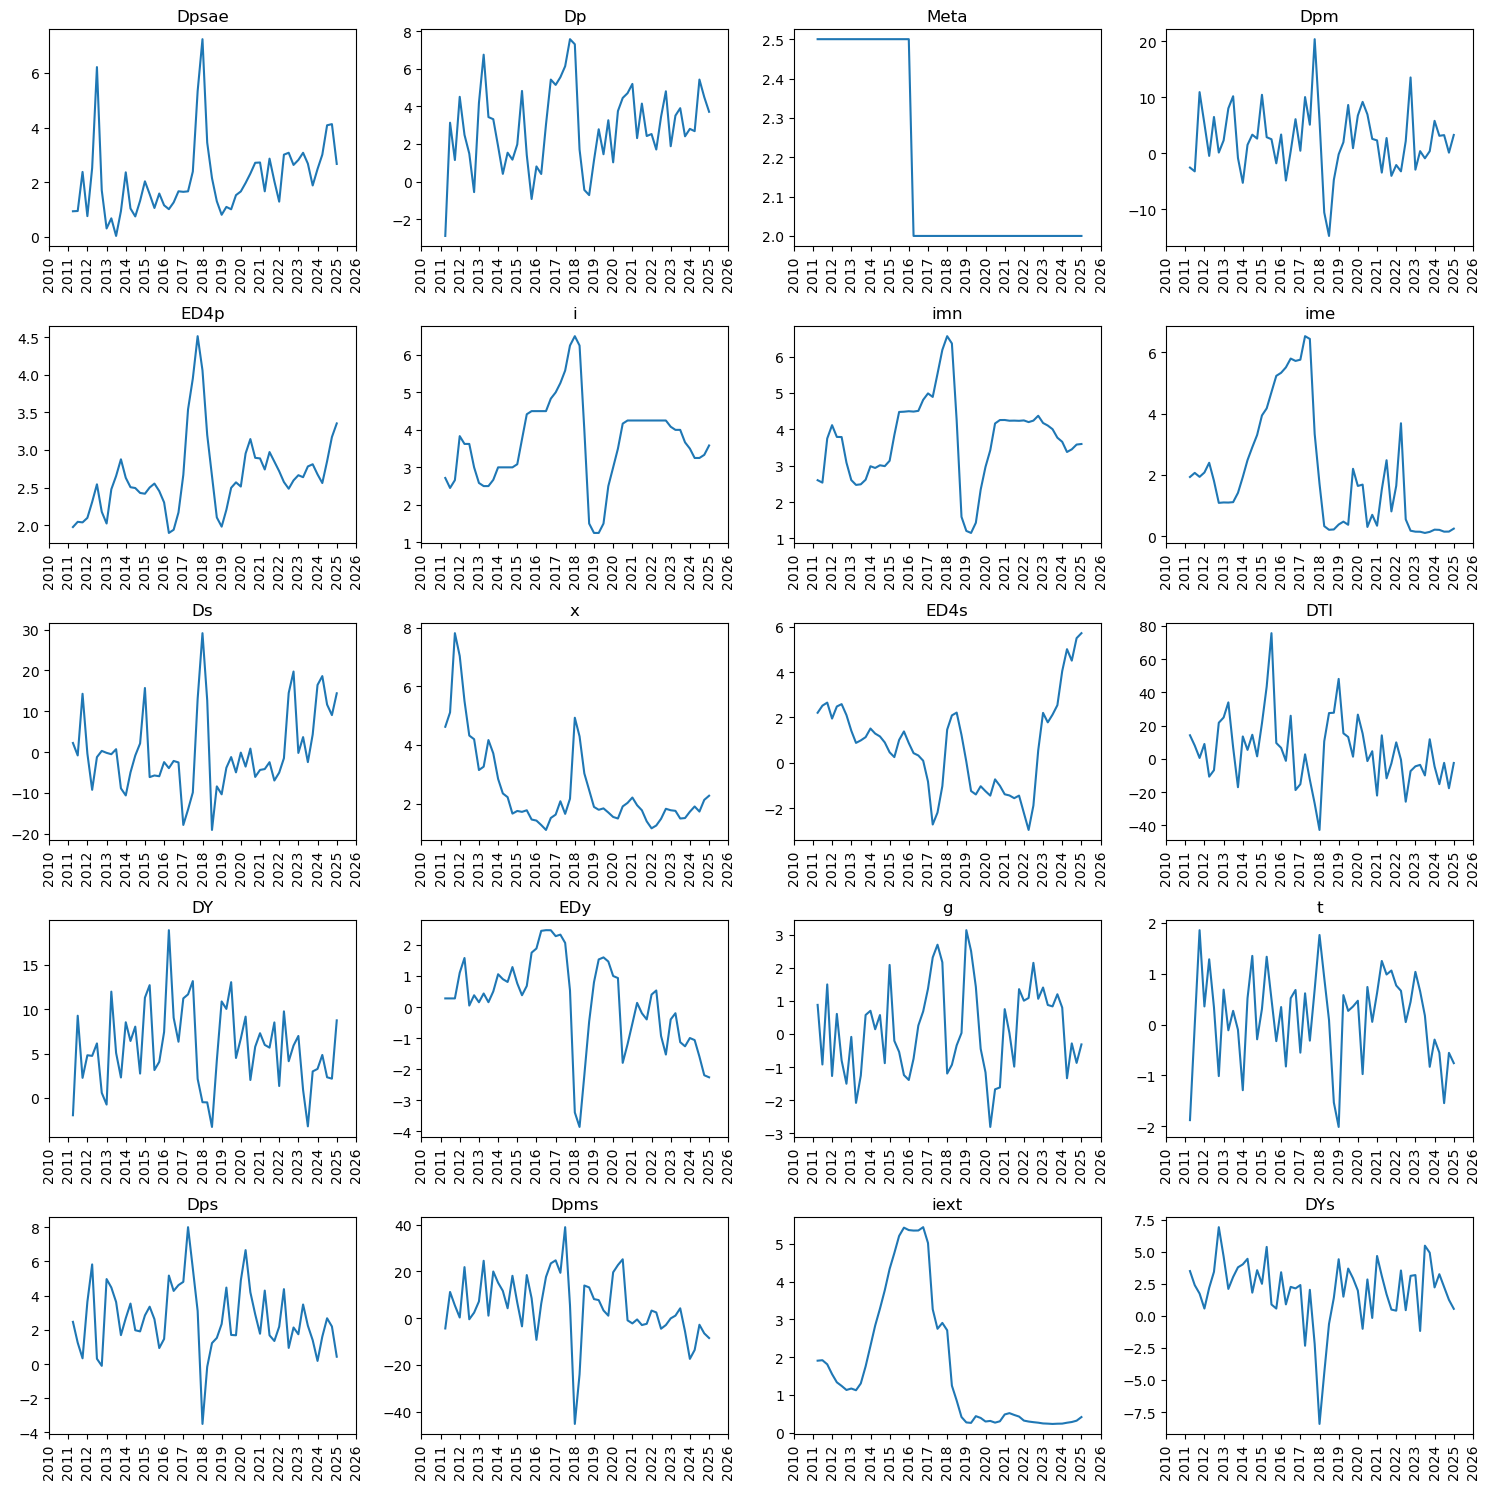

In [8]:
obsnames = DLM.sympy_to_list(Mod['StateSpaceForm']['obs_names'])
num_cols = len(obsnames)
num_rows = math.ceil(num_cols / 4)

fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 3))


for idx, col in enumerate(obsnames):
    row = idx // 4
    col_idx = idx % 4
    axs[row, col_idx].plot(DBobs.index, DBobs[col], linestyle='-')
    axs[row, col_idx].set_title(col)
    axs[row, col_idx].tick_params(axis='x', rotation = 90)
    axs[row, col_idx].set_xticks(axs[row, col_idx].get_xticks()[::4])

    axs[row, col_idx].xaxis.set_major_locator(mdates.YearLocator())
    axs[row, col_idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for idx in range(num_cols, num_rows * 4):
    fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

In [9]:
DF_s, DF_u, minuslogL = DLM.KFts(DBobs, Mod, {'diffuse':False})

In [10]:
SS = Mod['Solution']['Y0'].reshape(-1,1)


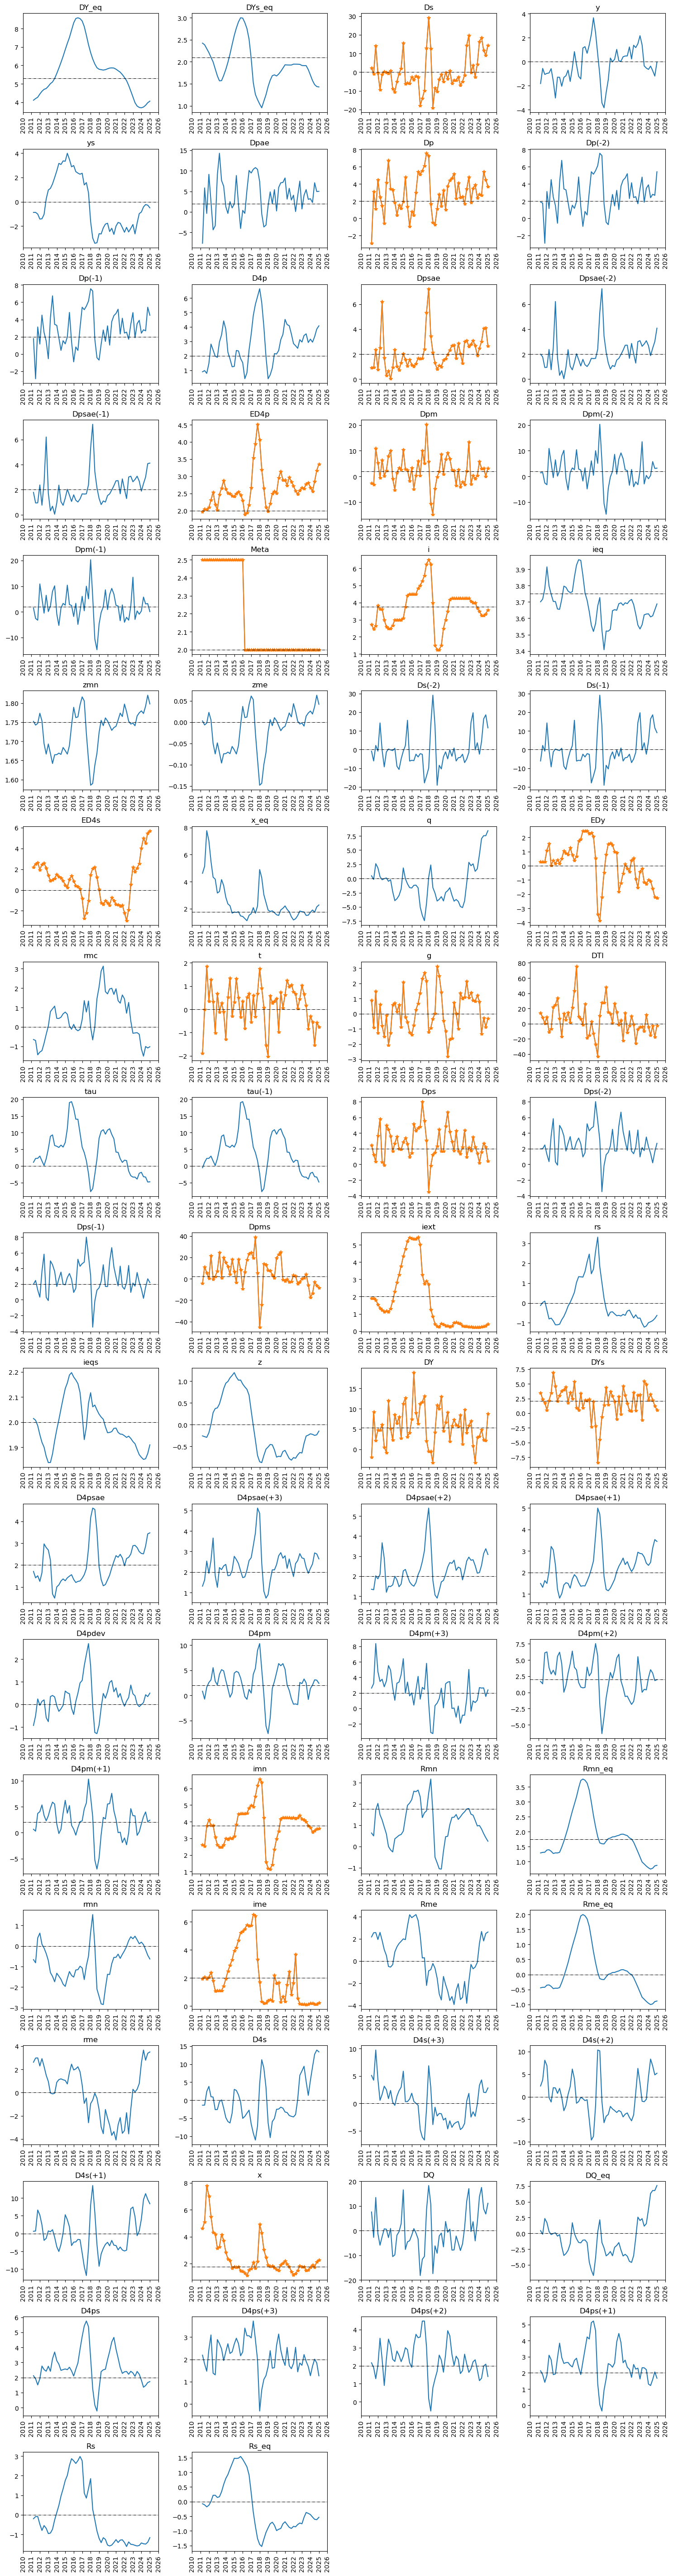

In [11]:
columns = DF_s.columns
num_cols = len(columns)
num_rows = math.ceil(num_cols / 4)

fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 3))


for idx, col in enumerate(columns):
    row = idx // 4
    col_idx = idx % 4
    axs[row, col_idx].plot(DF_s.index, DF_s[col], linestyle='-')
    axs[row, col_idx].set_title(col)
    observable = False
    for obs in obsnames:
        if col == obs:
            observable = True
    if observable:
        axs[row, col_idx].plot(DF_s.index, DBobs[col], linestyle='-',marker='*')
    axs[row, col_idx].tick_params(axis='x', rotation = 90)
    axs[row, col_idx].set_xticks(axs[row, col_idx].get_xticks()[::4])

    axs[row, col_idx].axhline(y=SS[idx], color='black', linestyle='-.', linewidth=0.75)

    axs[row, col_idx].xaxis.set_major_locator(mdates.YearLocator())
    axs[row, col_idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

for idx in range(num_cols, num_rows * 4):
    fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

In [12]:
Data = DF_s

# Forecast

1. Unconditional

In [13]:
FH = 8
FDB = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1')

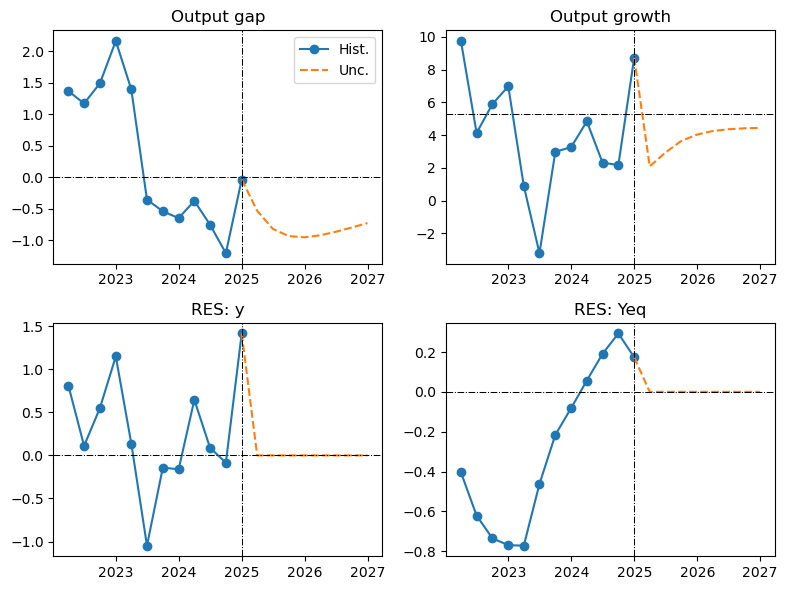

In [14]:
DBdict = {'Unc.': FDB}
lista = ['y','DY','res_y','res_DY_eq']
listanames = ['Output gap','Output growth','RES: y','RES: Yeq']
listaSS = [0,5.3,0,0]
HH = 12
Number_Rows = 2
Number_Cols = 2
fig, axs = HTS.plotTSforecast(DBdict,lista,listanames,listaSS,FH,HH,Number_Rows,Number_Cols)

BORRAR LUEGO

In [15]:
FDB_report_endog = FDB.loc[FDB.index[-(FH+4):]][var] \
                      .round(2) 

FDB_report_exog = FDB.loc[FDB.index[-(FH+4):]][varexo] \
                      .round(2) 

FDB_report_endog.index = FDB_report_endog.index.to_period('Q').strftime('%Y-Q%q')
FDB_report_exog.index = FDB_report_exog.index.to_period('Q').strftime('%Y-Q%q')

FDB_report_endog_pdf = FDB_report_endog.T
FDB_report_exog_pdf = FDB_report_exog.T

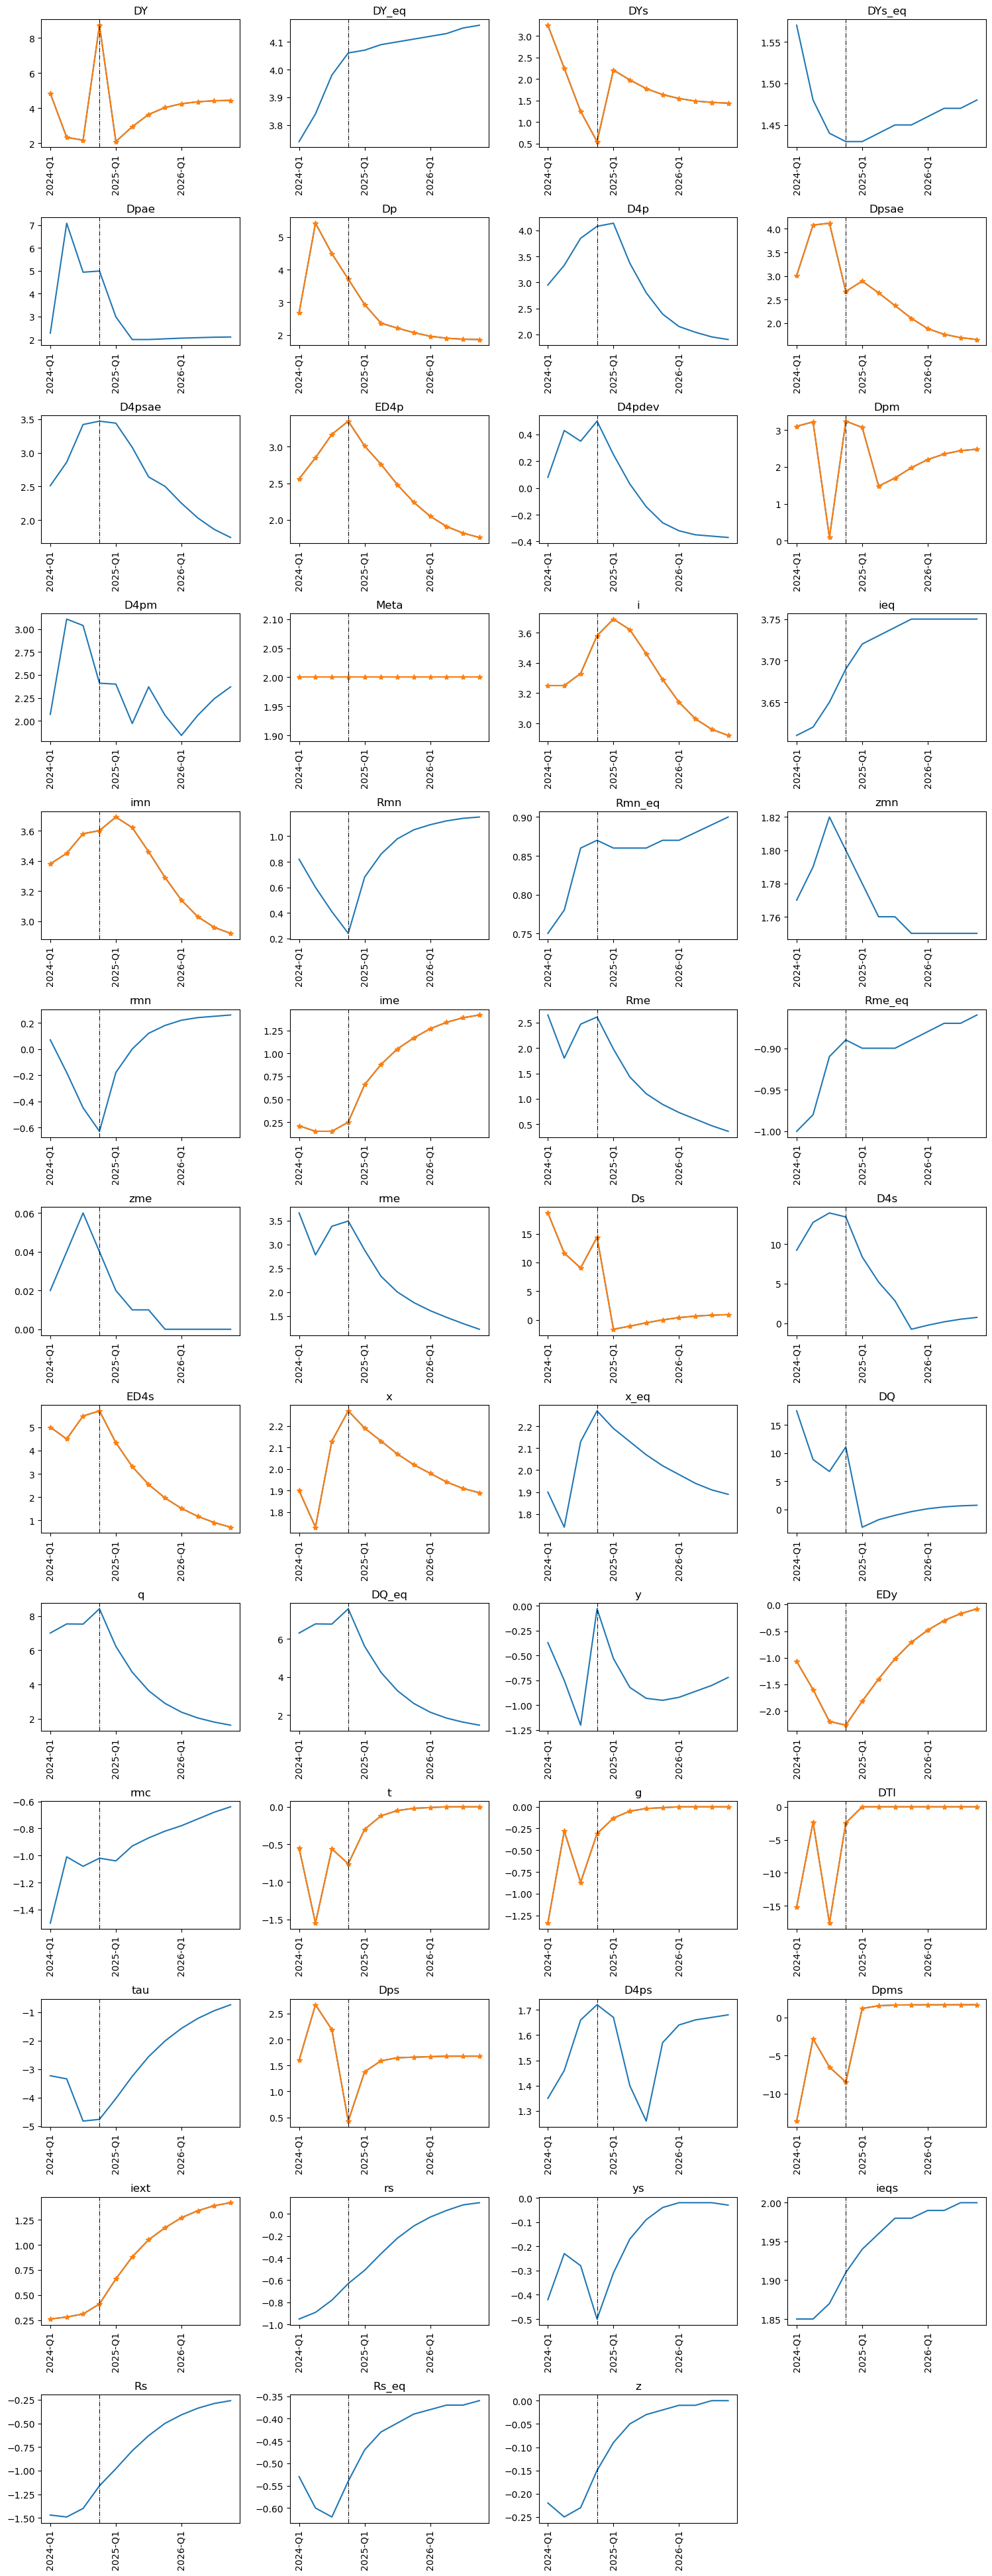

In [16]:
columns = FDB_report_endog.columns
num_cols = len(columns)
num_rows = math.ceil(num_cols / 4)

fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 3))


for idx, col in enumerate(columns):
    row = idx // 4
    col_idx = idx % 4
    axs[row, col_idx].plot(FDB_report_endog.index, FDB_report_endog[col], linestyle='-')
    axs[row, col_idx].set_title(col)
    observable = False
    for obs in obsnames:
        if col == obs:
            observable = True
    if observable:
        axs[row, col_idx].plot(FDB_report_endog.index, FDB_report_endog[col], linestyle='-',marker='*')
    axs[row, col_idx].tick_params(axis='x', rotation = 90)
    xticks = axs[row, col_idx].get_xticks()
    axs[row, col_idx].set_xticks(xticks[::4])

    if len(xticks) > 3:
        axs[row, col_idx].axvline(x=xticks[3], color='black', linestyle='-.', linewidth=0.75)


    #axs[row, col_idx].xaxis.set_major_locator(mdates.YearLocator())
    #axs[row, col_idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


for idx in range(num_cols, num_rows * 4):
    fig.delaxes(axs.flatten()[idx])

plt.tight_layout()
plt.show()

In [17]:
pdf_file = "FDB_report.pdf"
current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

with PdfPages(pdf_file) as pdf:
    # First page for FDB_report_endog
    fig, ax = plt.subplots(figsize=(8.5, 11))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    table = ax.table(cellText=FDB_report_endog_pdf.values,
                     colLabels=FDB_report_endog_pdf.columns,
                     rowLabels=FDB_report_endog_pdf.index,
                     cellLoc='center',
                     loc='center')

    fig.text(0.01, 0.99, f'Fecha de reporte: {current_datetime}', fontsize=10, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    adjust_column_widths(table, ax)

    fig.tight_layout(pad=3.0)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)

    # Second page for FDB_report_exog
    fig_exog, ax_exog = plt.subplots(figsize=(8.5, 11))
    ax_exog.xaxis.set_visible(False)
    ax_exog.yaxis.set_visible(False)
    ax_exog.set_frame_on(False)

    table_exog = ax_exog.table(cellText=FDB_report_exog.values,
                               colLabels=FDB_report_exog.columns,
                               rowLabels=FDB_report_exog.index,
                               cellLoc='center',
                               loc='center')

    fig_exog.text(0.01, 0.99, f'Fecha de reporte: {current_datetime}', fontsize=10, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))

    table_exog.auto_set_font_size(False)
    table_exog.set_fontsize(10)
    table_exog.scale(1.2, 1.2)

    adjust_column_widths(table_exog, ax_exog)

    fig_exog.tight_layout(pad=3.0)
    pdf.savefig(fig_exog, bbox_inches='tight')
    plt.close(fig_exog)

print(f"'{pdf_file}' created successfully.")

C:\Users\2663\AppData\Local\Temp\ipykernel_8792\3850568525.py:49: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig_exog.tight_layout(pad=3.0)


'FDB_report.pdf' created successfully.


2. Not anticipated conditional forecast

In [18]:
UCond = HTS.ReadForeCond('Riesgo/DataTarea_Exogenas_Riesgo5.xlsx','2025Q1', FH)

In [19]:
UCond['Uvar']['var'].i = FDB.i[-8:].values

In [20]:
print('Which are the assumptions?')
print('Unanticipated Softtunning')
print(UCond['UShock'])
print('Unanticipated Hardtunning')
print(UCond['Uvar']['var'])
print('-> Shocks to achieve hardtunning:')
print(UCond['Uvar']['shock'])

Which are the assumptions?
Unanticipated Softtunning
            res_Dps  res_ys
2025-03-31      NaN     NaN
2025-06-30      NaN     NaN
2025-09-30      NaN     NaN
2025-12-31      NaN     NaN
2026-03-31      NaN     NaN
2026-06-30      NaN     NaN
2026-09-30      NaN     NaN
2026-12-31      NaN     NaN
Unanticipated Hardtunning
            Meta      Dpae         g       EDy     DY_eq         x         i
2025-03-31   2.0  4.487568  0.373681 -2.574277  3.574066  2.443095  3.694081
2025-06-30   2.0  3.498147  0.449321 -2.150112  3.586325  2.375390  3.617677
2025-09-30   2.0  3.000552  0.479668 -1.522360  3.598462  2.268031  3.459067
2025-12-31   2.0  3.034655  0.491843 -1.213991  3.610477  2.219435  3.288516
2026-03-31   2.0  2.808835  0.246727 -0.725120  3.872373  2.128266  3.142403
2026-06-30   2.0  2.834970  0.248687 -0.546669  3.884149  2.093387  3.032633
2026-09-30   2.0  2.853786  0.249473 -0.417037  3.895807  2.013837  2.959103
2026-12-31   2.0  2.862211  0.249789 -0.325911  3.907

In [21]:
UFDB = DLM.DSGEforecast0(Mod,Data,FH,'2025Q1',UCond)

In [22]:
UFDB_report_endog = UFDB.loc[UFDB.index[-(FH+4):]][var] \
                      .round(2) 

UFDB_report_exog = UFDB.loc[UFDB.index[-(FH+4):]][varexo] \
                      .round(2)


UFDB_report_endog.index = UFDB_report_endog.index.to_period('Q').strftime('%Y-Q%q')
UFDB_report_exog.index = UFDB_report_exog.index.to_period('Q').strftime('%Y-Q%q')

UFDB_report_endog_pdf = UFDB_report_endog.T
UFDB_report_exog_pdf = UFDB_report_exog.T

In [ ]:
print(f'Impacto 2025: {round((UFDB.D4p[-5:-4][0] - FDB.D4p[-5:-4][0])*0.10, 2)}')
print(f'Impacto 2026: {round((UFDB.D4p[-1:][0] - FDB.D4p[-1:][0])*0.10, 2)}')

Impacto 2025: -0.06
Impacto 2026: -0.04


C:\Users\2663\AppData\Local\Temp\ipykernel_8792\1619171557.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2025: {round((FDB.D4p[-5:-4][0] - UFDB.D4p[-5:-4][0])*0.10, 2)}')
C:\Users\2663\AppData\Local\Temp\ipykernel_8792\1619171557.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Impacto 2026: {round((FDB.D4p[-1:][0] - UFDB.D4p[-1:][0])*0.10, 2)}')


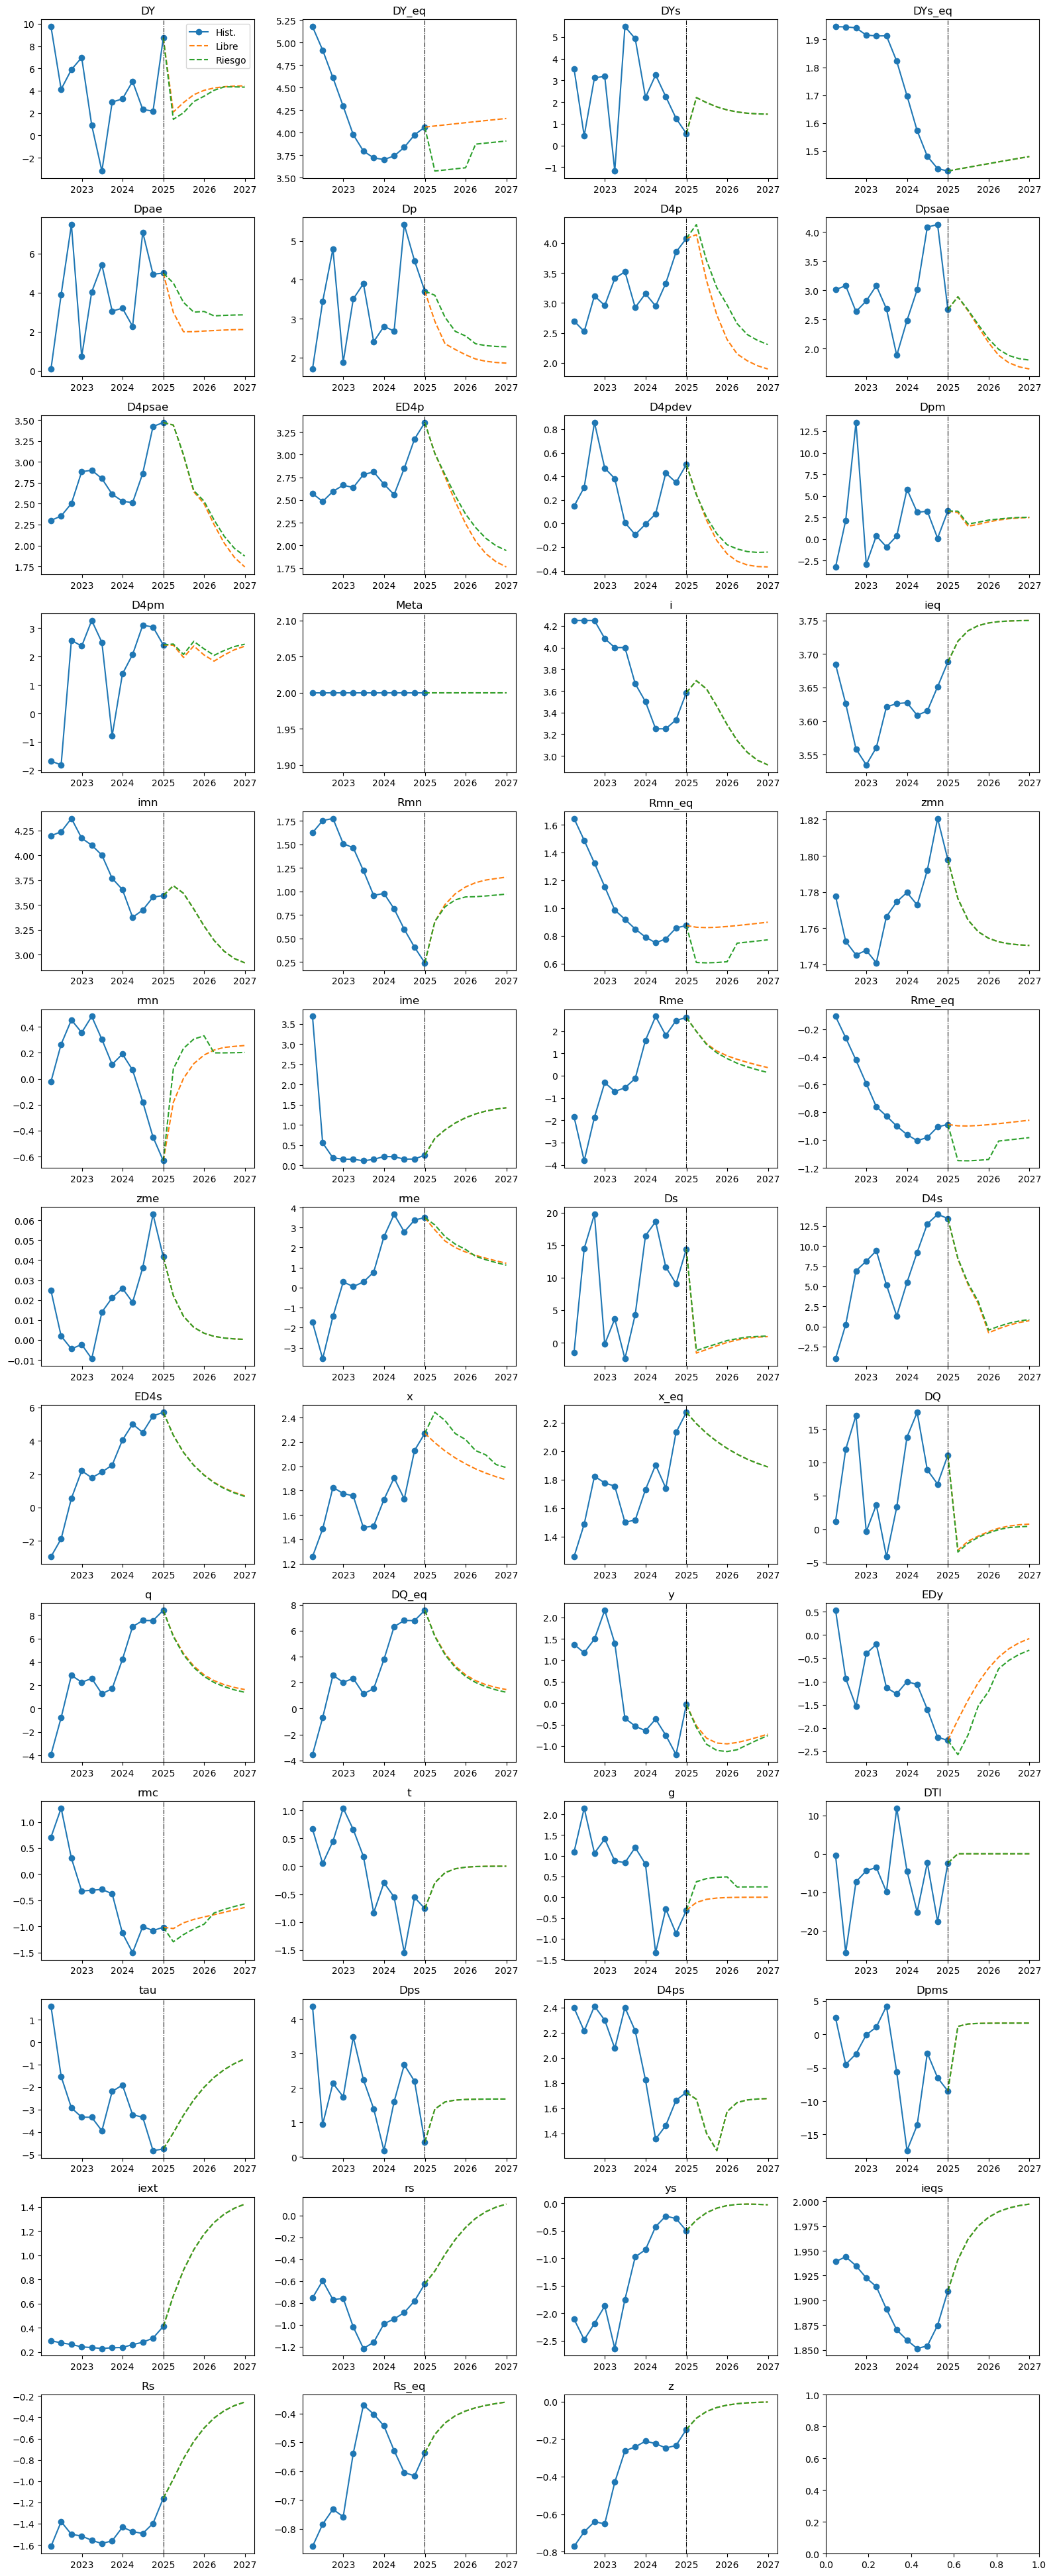

In [24]:
lista = UFDB_report_endog.columns
listaSS = [0 for x in lista]
listanames = lista

#BDdict = {'Libre': FDB_report_endog,'Riesgo': UFDB_report_endog}
BDdict = {'Libre': FDB,'Riesgo': UFDB}

num_cols = len(columns)
num_rows = math.ceil(num_cols / 4)

fig, axs = HTS.plotTSforecast(BDdict,lista,listanames,listaSS,FH,HH, num_rows, 4, SS_plot = False)

In [ ]:
pdf_file = "UFDB_report.pdf"
current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

with PdfPages(pdf_file) as pdf:
    # First page for FDB_report_endog
    fig, ax = plt.subplots(figsize=(8.5, 11))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)

    table = ax.table(cellText=UFDB_report_endog_pdf.values,
                     colLabels=UFDB_report_endog_pdf.columns,
                     rowLabels=UFDB_report_endog_pdf.index,
                     cellLoc='center',
                     loc='center')

    fig.text(0.01, 0.99, f'Fecha de reporte: {current_datetime}', fontsize=10, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    adjust_column_widths(table, ax)

    fig.tight_layout(pad=3.0)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)

    # Second page for FDB_report_exog
    fig_exog, ax_exog = plt.subplots(figsize=(8.5, 11))
    ax_exog.xaxis.set_visible(False)
    ax_exog.yaxis.set_visible(False)
    ax_exog.set_frame_on(False)

    table_exog = ax_exog.table(cellText=UFDB_report_exog_pdf.values,
                               colLabels=UFDB_report_exog_pdf.columns,
                               rowLabels=UFDB_report_exog_pdf.index,
                               cellLoc='center',
                               loc='center')

    fig_exog.text(0.01, 0.99, f'Fecha de reporte: {current_datetime}', fontsize=10, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))

    table_exog.auto_set_font_size(False)
    table_exog.set_fontsize(10)
    table_exog.scale(1.2, 1.2)

    adjust_column_widths(table_exog, ax_exog)

    fig_exog.tight_layout(pad=3.0)
    pdf.savefig(fig_exog, bbox_inches='tight')
    plt.close(fig_exog)

print(f"'{pdf_file}' created successfully.")

'UFDB_report.pdf' created successfully.


* Intento de reporteador

Aquí se ve que la confianza ```EDy``` y las condicniones monetarias ```rmc``` explican principalmente la brecha

In [ ]:
# Intento de reporteador
#y = ay*y(-1) + aEy*(y(-1) + EDy) + armc*rmc(-1) - at*t + ag*g + aq*q + atau*tau+ ays*ys + m_res_y*res_y

ay = 0.539500000000000
aEy = 0.127700000000000
armc = 0.300000000000000
at = 0.005000000000000
ag = 0.115200000000000
ays = 0.055100000000000
atau = 0.020500000000000
aq = 0.023200000000000
m_res_y = (0.900300000000000)**0.5

hist2show = 4

y     = UFDB['y'].values[-(hist2show+FH):].reshape(-1,1)
yl    = (ay+aEy)*UFDB['y'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
yEDy  = aEy*UFDB['EDy'].values[-(hist2show+FH):].reshape(-1,1)
rmc   = armc*UFDB['rmc'].values[-((hist2show+FH)+1):-1].reshape(-1,1)
t     = -at*UFDB['t'].values[-(hist2show+FH):].reshape(-1,1)
g     = ag*UFDB['g'].values[-(hist2show+FH):].reshape(-1,1)
q     = aq*UFDB['q'].values[-(hist2show+FH):].reshape(-1,1)
tau   = atau*UFDB['tau'].values[-(hist2show+FH):].reshape(-1,1)
ys    = ays*UFDB['ys'].values[-(hist2show+FH):].reshape(-1,1)
res_y = m_res_y*UFDB['res_y'].values[-(hist2show+FH):].reshape(-1,1)
pd.DataFrame(np.c_[y,yl,yEDy,rmc,t,g,q,tau,ys,res_y], columns=['y','(ay+aEy)*y(-1)','aEy*EDy','armc*rmc(-1)','-at*t','ag*g','aq*q','atau*tau','ays*ys','m_res_y*res_y'], index=UFDB.index[-(hist2show+FH):]).T

,2024-03-31,2024-06-30,2024-09-30,2024-12-31,2025-03-31,2025-06-30,2025-09-30,2025-12-31,2026-03-31,2026-06-30,2026-09-30,2026-12-31
y,-0.372058,-0.749937,-1.201698,-0.034537,-0.447834,-0.671780,-0.733699,-0.714978,-0.658925,-0.592111,-0.523534,-0.456910
(ay+aEy)*y(-1),-0.430945,-0.248237,-0.500358,-0.801773,-0.023043,-0.298795,-0.448212,-0.489524,-0.477033,-0.439635,-0.395057,-0.349302
aEy*EDy,-0.136213,-0.204320,-0.280940,-0.289453,-0.169110,-0.114944,-0.066705,-0.027327,0.003177,0.025965,0.042519,0.054156
armc*rmc(-1),-0.339501,-0.451219,-0.301934,-0.324542,-0.305547,-0.314725,-0.283699,-0.267282,-0.256823,-0.247929,-0.237882,-0.226368
-at*t,0.002764,0.007736,0.002787,0.003799,0.001490,0.000585,0.000229,0.000090,0.000035,0.000014,0.000005,0.000002
ag*g,-0.153978,-0.032631,-0.100608,-0.036271,-0.014552,-0.005838,-0.002342,-0.000940,-0.000377,-0.000151,-0.000061,-0.000024
aq*q,0.162716,0.174880,0.174753,0.195245,0.144401,0.108798,0.083044,0.064830,0.052098,0.043073,0.036522,0.031607
atau*tau,-0.066133,-0.068470,-0.098857,-0.097495,-0.070170,-0.040163,-0.013905,0.004073,0.017242,0.023796,0.027665,0.030264
ays*ys,-0.023415,-0.012813,-0.015377,-0.027463,-0.011303,-0.006697,-0.002108,0.001102,0.002755,0.002755,0.002755,0.002755
m_res_y*res_y,0.612646,0.085137,-0.081166,1.343416,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
